In [1]:
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [2]:
mat_data = sio.loadmat(fr'subject_data\data-science-P1.mat')
data = mat_data['data']
info = mat_data['info'][0]
meta = mat_data['meta'][0]

for i in info[:20]:
    print(i['cond'], i['cond_number'])

['manmade'] [[10]]
['building'] [[4]]
['manmade'] [[10]]
['manmade'] [[10]]
['buildpart'] [[5]]
['tool'] [[11]]
['building'] [[4]]
['furniture'] [[7]]
['animal'] [[2]]
['kitchen'] [[9]]
['vehicle'] [[13]]
['insect'] [[8]]
['vegetable'] [[12]]
['bodypart'] [[3]]
['bodypart'] [[3]]
['furniture'] [[7]]
['kitchen'] [[9]]
['vehicle'] [[13]]
['building'] [[4]]
['clothing'] [[6]]


In [3]:
def load_all_subjects():
    all_trial_data = []
    all_categories = []
    
    # First pass: collect voxel counts and find common voxels
    voxel_coords = None
    
    # Check each subject's voxel coordinates
    for subject in range(1, 10):
        mat_data = sio.loadmat(f'subject_data/data-science-P{subject}.mat')
        meta = mat_data['meta'][0]
        subject_coords = meta['colToCoord'][0]  # Get voxel coordinates
        
        if voxel_coords is None:
            voxel_coords = set(map(tuple, subject_coords))
        else:
            # Keep only coordinates present in all subjects
            voxel_coords &= set(map(tuple, subject_coords))
    
    # Convert back to array for indexing
    common_coords = np.array(list(voxel_coords))
    
    # Second pass: load data using only common voxels
    for subject in range(1, 10):
        # Load subject data
        mat_data = sio.loadmat(f'subject_data/data-science-P{subject}.mat')
        data = mat_data['data']
        info = mat_data['info'][0]
        meta = mat_data['meta'][0]
        
        # Get mapping from this subject's coordinates to common coordinates
        subject_coords = meta['colToCoord'][0]
        coord_to_idx = {tuple(coord): idx for idx, coord in enumerate(subject_coords)}
        common_indices = [coord_to_idx[tuple(coord)] for coord in common_coords]
        
        # Process all trials
        subject_trials = []
        for trial_idx in range(len(info)):
            # Get trial data but only for common voxels
            trial_data = data[trial_idx][0][0][common_indices]
            subject_trials.append(trial_data)
            all_categories.append(info[trial_idx]['cond'][0])
        
        # Convert to numpy array for normalization
        subject_trials = np.array(subject_trials)
        
        # Normalize subject's data
        mean = subject_trials.mean(axis=0)
        std = subject_trials.std(axis=0)
        subject_trials_normalized = (subject_trials - mean) / std
        
        # Add to main lists
        all_trial_data.extend(subject_trials_normalized)
    
    # Convert to numpy arrays
    X = np.array(all_trial_data)
    y = np.array(all_categories)
    
    print(f"Using {len(common_coords)} common voxels across all subjects")
    label_encoder = LabelEncoder()
    encoded_y = label_encoder.fit_transform(y)
    return X, encoded_y, label_encoder

X, y, label_encoder = load_all_subjects()


Using 17326 common voxels across all subjects


In [4]:
class BrainActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [6]:
train_dataset = BrainActivityDataset(X_train, y_train)
test_dataset = BrainActivityDataset(X_test, y_test)

In [7]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,       # number of samples per batch
    shuffle=True,        # shuffle training data each epoch
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,       # no need to shuffle test data
)

In [8]:
class BrainActivityClassifier(nn.Module):
    def __init__(self, input_dim = 21764, num_classes = 12):
        super().__init__()

        # simpler arch to try reducing overfitting
        self.model = nn.Sequential(
            # First layer: big reduction
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            
            # Single hidden layer
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            
            # Output layer
            nn.Linear(64, num_classes)
        )

        # # original arch
        # self.model = nn.Sequential(
        #     nn.Linear(input_dim, 512),
        #     nn.BatchNorm1d(512),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.6),

        #     nn.Linear(512, 256),
        #     nn.BatchNorm1d(256),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.5),

        #     nn.Linear(256, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     nn.Dropout(p=0.4),

        #     nn.Linear(128, num_classes)
        # )
    
    def _init_weights(self):
       for m in self.model:
           if isinstance(m, nn.Linear):
               nn.init.kaiming_normal_(m.weight)
               nn.init.constant_(m.bias, 0)

    def forward(self, x):
       return self.model(x)

In [9]:
class DeepBrainClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=12):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            # Initial feature extraction
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            # Progressive feature refinement
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device = "cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * (correct/total)
    return epoch_loss, epoch_acc    


In [11]:
def validate(model, val_loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * (correct/total)
    return val_loss, val_acc, all_preds, all_labels


In [12]:
input_dim = X.shape[1]
model = BrainActivityClassifier(input_dim=input_dim)
# model = DeepBrainClassifier(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
   model.parameters(),
   lr=0.001,
   weight_decay=1e-3  # L2 regularization
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
   optimizer, 
   mode='min', 
   factor=0.5, 
   patience=5,
   verbose=True
)

c:\Users\ishui\anaconda3\envs\neuro\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
num_epochs = 80
best_val_loss = float('inf')
patience = 50
patience_counter = 0


# Training history
train_losses = []
train_accs = []
val_losses = []
val_accs = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, epoch_preds, epoch_labels = validate(model, test_loader, criterion, device)
    
    # Save final epoch predictions
    if epoch == num_epochs - 1 or patience_counter >= patience - 1:
        print("hi")
        final_preds = epoch_preds
        final_labels = epoch_labels 

    # Update learning rate
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

cuda
Epoch 1/80:
Train Loss: 2.6128, Train Acc: 8.56%
Val Loss: 2.4852, Val Acc: 10.65%
Epoch 2/80:
Train Loss: 2.5325, Train Acc: 10.26%
Val Loss: 2.4633, Val Acc: 13.12%
Epoch 3/80:
Train Loss: 2.4722, Train Acc: 12.77%
Val Loss: 2.4244, Val Acc: 16.67%
Epoch 4/80:
Train Loss: 2.3924, Train Acc: 16.05%
Val Loss: 2.3761, Val Acc: 19.91%
Epoch 5/80:
Train Loss: 2.3290, Train Acc: 17.01%
Val Loss: 2.3242, Val Acc: 20.52%
Epoch 6/80:
Train Loss: 2.2485, Train Acc: 22.88%
Val Loss: 2.2820, Val Acc: 23.46%
Epoch 7/80:
Train Loss: 2.1689, Train Acc: 25.46%
Val Loss: 2.2365, Val Acc: 22.99%
Epoch 8/80:
Train Loss: 2.1256, Train Acc: 26.85%
Val Loss: 2.1845, Val Acc: 25.15%
Epoch 9/80:
Train Loss: 2.0532, Train Acc: 29.86%
Val Loss: 2.1558, Val Acc: 27.31%
Epoch 10/80:
Train Loss: 2.0073, Train Acc: 29.98%
Val Loss: 2.1167, Val Acc: 26.08%
Epoch 11/80:
Train Loss: 1.9405, Train Acc: 33.02%
Val Loss: 2.1284, Val Acc: 27.62%
Epoch 12/80:
Train Loss: 1.9181, Train Acc: 34.18%
Val Loss: 2.1177, V

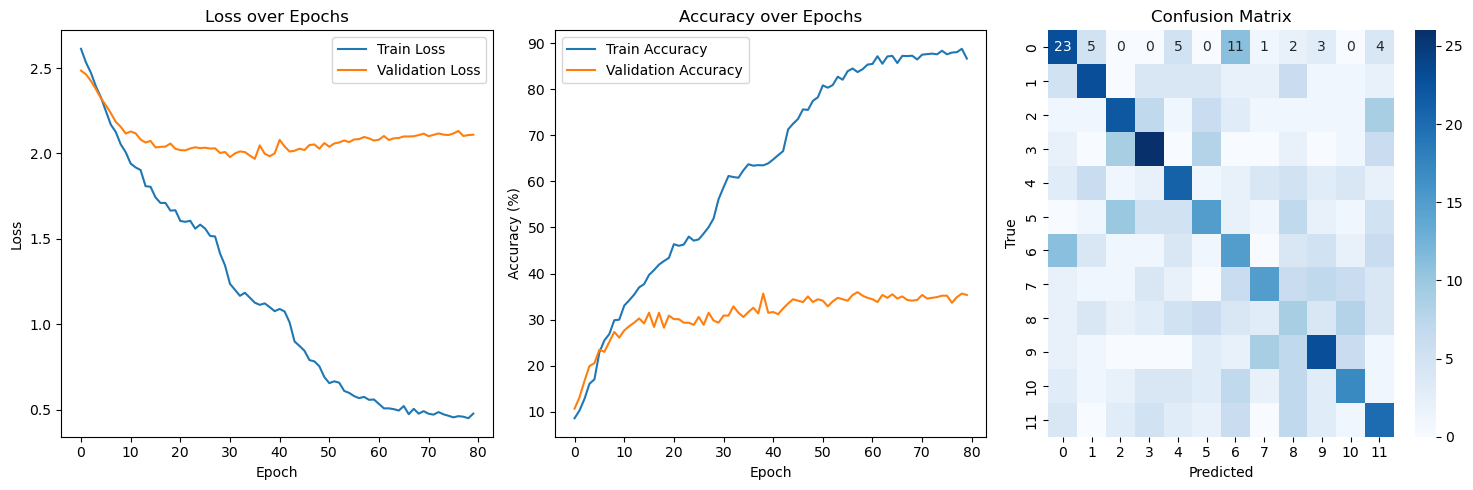


Best Validation Accuracy: 35.96% at epoch 58
Final Train/Val Gap: 51.35%


In [14]:
# After training loop ends, add visualization code:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Confusion matrix
plt.subplot(1, 3, 3)
conf_mat = confusion_matrix(final_labels, final_preds)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Print best results
best_epoch = val_accs.index(max(val_accs))
print(f"\nBest Validation Accuracy: {max(val_accs):.2f}% at epoch {best_epoch+1}")
print(f"Final Train/Val Gap: {train_accs[-1] - val_accs[-1]:.2f}%")

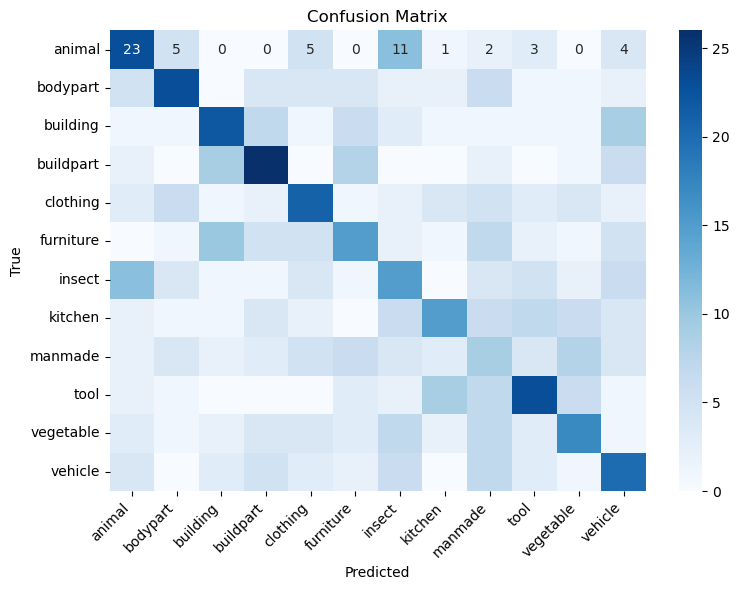

In [15]:
def plot_confusion_matrix(final_labels, final_preds, label_encoder):
    categories = label_encoder.classes_
    plt.figure(figsize=(8, 6))
    conf_mat = confusion_matrix(final_labels, final_preds)
    sns.heatmap(conf_mat, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=categories,
                yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(final_labels, final_preds, label_encoder)